In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re, os, math, random
from collections import Counter
from collections import defaultdict
import operator
from tqdm import tqdm
import jieba
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Bidirectional, CuDNNGRU, CuDNNLSTM, Conv1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tensorflow.python.ops import tensor_array_ops, control_flow_ops
import gc

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
jieba.enable_parallel(8)
train_corpus = "train_first.csv"
test_corpus = "predict_first.csv"
vocab_path = "Chinese_corpus_dict.vocab"
clean_stop_word = False
vocab_size = 20000
embedding_dims = 300
seq_length = 100
pointer = 0

#####################
## Text RNN
rnn_recurrent_units = 48
rnn_dense_units = 32
rnn_output_units = 5
rnn_batch_size = 256
#####################

#####################
## Text CNN
cnn_filter_nums = 120
cnn_dense_units = 72
cnn_output_units = 5
cnn_batch_size = 256
#####################

#####################
## Hybrid Text NN
hy_recurrent_units = 48
hy_filter_nums = 64
hy_output_units = 5
hy_batch_size = 256
#####################

#####################
## Seq2seq
seq_batch_size = 50
enc_hidden_size = 150
dec_hidden_size = 300
seq_learning_rate = 0.01
start_word = 2    # token number of <SOS>
train_epochs = 10
dropout_keep_prob = 0.75
l2_reg_lambda = 0.2
seq_label_size = 5
#####################

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.791 seconds.
Prefix dict has been built succesfully.


# Data Analysis

In [3]:
train_df = pd.read_csv(train_corpus)
test_df = pd.read_csv(test_corpus)

train_df.sample(100)

,Id,Discuss,Score
24702,d5847c20-f2a6-3780-89da-145aa6dc1807,= =少林寺来都来了还不去看看。。。,3
64138,b0c14b5a-edc9-3163-bcdd-cf828cd41068,还可以,4
62780,73819238-7d44-3e95-9c9b-1eb804eeac57,不来后悔，来了受罪。,3
91591,ebdce98e-3a1e-36e2-a8ac-62e95bcd3e84,晚上去的，听说每天晚上8点都有放烟火。白天门票比晚上贵一半，很适合我。。。,5
36856,08234d60-0efe-3d2f-9d56-0ab603338d72,有人说“西溪湿地，独胜于水”，水是西溪的灵魂，园区约70%的面积为河港、池塘、湖漾、沼泽等水...,4
72419,8417ce0c-e9fd-3f7e-aaf6-ac9530aefa18,还行吧,4
80384,88da9f98-8c6c-3fe7-b231-9c35286a56f2,真得很震撼，但是看到佛像风化的这么严重，真得很心痛,5
19734,3b731fe5-fd6f-37eb-9af6-83ba494e3374,一片开阔的山顶平台上，有一对看似摇摇欲坠，实则稳如磐石的巨石--磐陀石，相传这里就是观音大士...,3
31362,49bc454e-25eb-3448-beb4-54cd7ec3ab80,到西安不去秦始皇兵马俑总觉得会有遗憾，博物馆还是挺大的，但是建议要带解说，即使需要花钱。如果...,5
72206,3ccc6dc9-a5d7-34cb-ba01-97d2459ec87f,玩的很开心,5


In [4]:
label_cols = pd.unique(train_df['Score'])
print(label_cols)

[5 4 3 2 1]


In [5]:
train_df.describe()

,Score
count,100000.000000
mean,4.470010
std,0.752134
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
test_df.head()

,Id,Discuss
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味 很喜欢这样有文化的地方
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈～
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间


In [7]:
# Data length
print("Total rows in train_corpus is {}".format(len(train_df)))
print("Total rows in test_corpus is {}".format(len(test_df)))
print(train_df['Score'].value_counts())

Total rows in train_corpus is 100000
Total rows in test_corpus is 30000
5    60097
4    28954
3     9389
2      973
1      587
Name: Score, dtype: int64


In [8]:
# Sentence length analysis
train_df['Word_Length'] = train_df['Discuss'].apply(lambda x: len(str(x)))
train_df

,Id,Discuss,Score,Word_Length
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,2
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,55
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,4
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,5


In [9]:
# print(train_df['Word_Length'].value_counts().head())

# For test_data
test_df['Word_Length'] = test_df['Discuss'].apply(lambda x: len(str(x)))
# print(test_df['Word_Length'].value_counts().head())
print(train_df['Word_Length'].describe(), "\n", test_df['Word_Length'].describe())

count    100000.000000
mean         48.283500
std          78.522278
min           1.000000
25%           9.000000
50%          24.000000
75%          52.000000
max        1336.000000
Name: Word_Length, dtype: float64 
 count    30000.000000
mean        49.249733
std         77.584046
min          1.000000
25%         11.000000
50%         25.000000
75%         54.000000
max       1136.000000
Name: Word_Length, dtype: float64


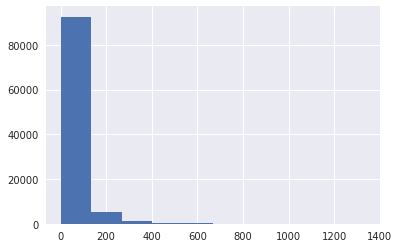

In [10]:
# histogram graph
sns.set()
train_df['Word_Length'].hist()
plt.show()

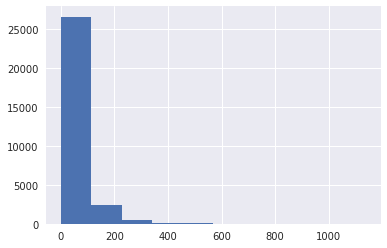

In [11]:
plt.figure()
plt.hist(test_df['Word_Length'])
plt.show()

In [12]:
train_df.sort_values('Word_Length', ascending=False).head(100)['Score'].value_counts()

5    56
4    31
3    12
1     1
Name: Score, dtype: int64

In [13]:
# transform to one-hot
Score = train_df['Score']
data = pd.get_dummies(Score)
train_df = pd.concat([train_df, data], axis=1)
train_df.head()

,Id,Discuss,Score,Word_Length,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,37,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,31,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,35,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,61,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,6,0,0,0,0,1


## Get positive labels

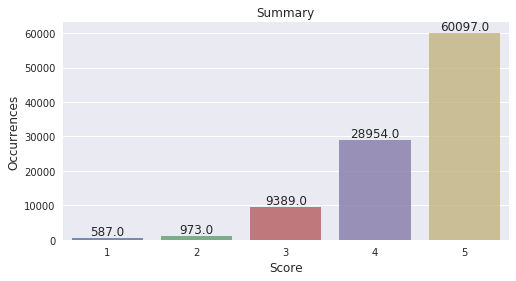

In [14]:
x = train_df.iloc[:, 4:].sum()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Summary")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Score', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, ha='center', va='bottom', s='{:.1f}'.format(abs(label)))
    
plt.show()

## Correlations of labels

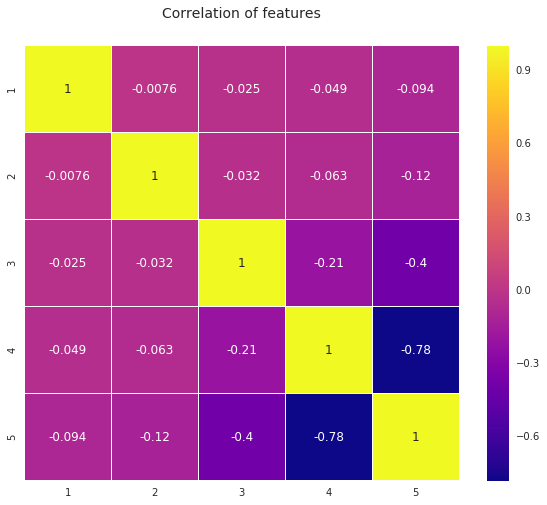

In [15]:
# No sentences contains up to 2 Score-labels
colormap = plt.cm.plasma
plt.figure(figsize=(10, 8))
plt.title('Correlation of features', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Processing

In [16]:
def clean_text(text, stem_words=False):
    text = re.sub(r',', '，', text)
    text = re.sub(r'\.+', '...', text)
    text = re.sub(r'\.{6}', '...', text)
    text = re.sub(r'…', '...', text)
    text = re.sub(r';', '；', text)
    text = re.sub(r'°', '。', text)
    text = re.sub(r'】', ']', text)
    text = re.sub(r'【', '[', text)
    text = re.sub(r'\)', '\）', text)
    text = re.sub(r'\(', '\（', text)
    text = re.sub(r'“', '"', text)
    text = re.sub(r' ', '', text)
    text = re.sub(r'”', '"', text)
    text = re.sub(r'～', '~', text)
    text = re.sub(r'·', '。', text)
    text = re.sub(r'!', '！', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'》', '\）', text)
    text = re.sub(r'《', '\（', text)
    text = re.sub(r'\?', '\？', text)
    text = re.sub(r'。。。', '...', text)
    text = re.sub(r'。。。。。。', '...', text)
    text = re.sub(r':', '：', text)
    
#     # for English_sentence
#     text = replace_numbers.sub('', text)
#     text = special_character_removal.sub('', text)
#     if stem_words:
#         text = text.split()
#         stemmer = SnowballStemmer('english')
#         stemmed_words = [stemmer.stem(word) for word in text]
#         text = " ".join(stemmed_words)
    
    return text

# regex to remove all Non-Alpha Numeric and space
special_character_removal = re.compile(r'[^a-z\d ]', re.IGNORECASE)

# regex to remove all Alpha Numeric and space
special_alpha_removal = re.compile(r'[a-z\d ]', re.IGNORECASE)

# regex to replace all numeric
replace_numbers = re.compile(r'\d+', re.IGNORECASE)

In [17]:
# Check NaN
print(np.any(train_df.isnull()) == True, np.any(test_df.isnull()) == True)

False False


In [18]:
# Regular dictionary
print("MSG : Processing text datasets...")
cols_target = [1, 2, 3, 4, 5]

list_sentence_train = train_df['Discuss'].fillna("no discuss").values
train_discusses = [clean_text(text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)

list_sentence_test = test_df['Discuss'].fillna("no discuss").values
test_discusses = [clean_text(text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)

# cleaned_train_discuss = []
# for i in range(len(train_df)):
#     cleaned_discuss = clean_text(train_df['Discuss'][i])
#     cleaned_train_discuss.append(cleaned_discuss)
# train_df['Discuss'] = pd.Series(cleaned_train_discuss).astype(str)

# cleaned_test_discuss = []
# for i in range(len(test_df)):
#     cleaned_discuss = clean_text(test_df['Discuss'][i])
#     cleaned_test_discuss.append(cleaned_discuss)
# test_df['Discuss'] = pd.Series(cleaned_test_discuss).astype(str)
# test_df.head()

MSG : Processing text datasets...


In [19]:
# Clean up the sentence text & Word segmentation analysis
word_dict = defaultdict(int)

for sentence in tqdm(train_df['Discuss']):
    seg_list = jieba.cut(sentence, cut_all=False)
    for word in seg_list:
        word_dict[word] += 1
word_dict = sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True)
word_dict
print(len(word_dict))

100%|██████████| 100000/100000 [00:44<00:00, 2239.20it/s]

88384


## A quick view of vocabulary

In [20]:
chinese_list, sign_list, dig_english_list = [], [], []
for word, count in word_dict:
    for char in word:
        if char >= u'\u4E00' and char <= u"\u9FA5":
            chinese_list.append((word, count))
        elif (char >= u'\u0041' and char <= u'\u005A') or (char >= u'\u0061' and char <= u'\u007A') or (char >= u'\u0030' and char <= u'\u0039'):
            dig_english_list.append((word, count))
            break
        else:
            sign_list.append((word, count))
            break
sorted_dig_english_list = sorted(set(dig_english_list), key=lambda x: x[1], reverse=True)
sorted_sign_list = sorted(set(sign_list), key=lambda x: x[1], reverse=True)
sorted_chinese_list = sorted(set(chinese_list), key=lambda x: x[1], reverse=True)
print("chinese_word: ", len(sorted_chinese_list))
print("dig_english_word: ", len(sorted_dig_english_list))
print("sign_count: ", len(sorted_sign_list))
print(sorted_chinese_list[:10000], '\n\n', sorted_dig_english_list[:50], '\n\n', sorted_sign_list[:20])

chinese_word:  84768
dig_english_word:  3046
sign_count:  573
[('的', 161679), ('了', 43115), ('是', 42184), ('很', 30622), ('去', 26710), ('在', 24941), ('有', 22118), ('也', 17749), ('都', 16584), ('好', 14719), ('就', 14467), ('可以', 14124), ('不错', 13325), ('我', 12365), ('人', 11654), ('和', 11515), ('到', 11449), ('不', 10688), ('还', 9684), ('地方', 9463), ('景区', 9329), ('一个', 9325), ('就是', 8760), ('还是', 8362), ('非常', 8061), ('看', 8018), ('没有', 7675), ('要', 7669), ('很多', 7623), ('值得', 7557), ('上', 7371), ('这里', 7065), ('我们', 7010), ('景点', 6773), ('多', 6622), ('感觉', 6577), ('风景', 6565), ('来', 6194), ('时候', 5980), ('走', 5976), ('比较', 5561), ('但是', 5535), ('美', 5115), ('里面', 5058), ('景色', 4974), ('门票', 4828), ('真的', 4819), ('着', 4802), ('大', 4663), ('吧', 4586), ('看到', 4526), ('会', 4494), ('还有', 4459), ('从', 4360), ('你', 4327), ('说', 4176), ('没', 4144), ('元', 4034), ('不过', 3955), ('玩', 3924), ('北京', 3900), ('时间', 3888), ('但', 3805), ('特别', 3765), ('西湖', 3677), ('中', 3656), ('最', 3656), ('这', 3601), ('个'

In [21]:
# create stop words
chinese_stop_words = [word[0] for word in sorted_chinese_list[vocab_size - 24:]]
english_stop_words = [word[0] for word in sorted_dig_english_list]
sign_stop_words = [word[0] for word in sorted_sign_list[20:]]
stop_words = chinese_stop_words + english_stop_words + sign_stop_words
print(len(stop_words))

68391


In [22]:
train_df = train_df.drop('Word_Length', axis=1)
train_df

,Id,Discuss,Score,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了2次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1
5,3b7f3f2e-886f-3a68-a810-2c37cfd728d3,方便,4,0,0,0,1,0
6,88914409-bd13-3d47-b5a2-691177dde8fd,看水看山都可以。感受古人的智慧结晶，秋景美丽如画，红黄绿相间！对于身体状况不佳的人来说，走平...,4,0,0,0,1,0
7,bf13ec92-6079-3451-ade3-88020cb0dcb5,赞,5,0,0,0,0,1
8,489c3d94-9c44-3cf2-949c-1b507c374c69,唯一糟点,5,0,0,0,0,1
9,285bba78-16a3-3c1d-b648-baa483883ee3,周未周边游,5,0,0,0,0,1


In [23]:
train_data = train_df.Discuss.values
train_label = train_df['Score'].values
test_data = test_df.Discuss.values
print(train_data.shape, test_data.shape, train_label.shape)

(100000,) (30000,) (100000,)


## sample balance datasets

In [24]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
shuffled_train_df 

,Id,Discuss,Score,1,2,3,4,5
3710,349f10d8-8108-33d5-8b4c-ef1d7764b19e,这个是卤煮，我就是冲这个来的，不过吃了几口也没什么感觉。炸灌肠，不知道成分是什么，完全吃不来...,4,0,0,0,1,0
44118,a103c578-3edd-3cb5-b152-620dfd4084e9,值得一去，虽然没有想象中那么美。但是也不辜负去一趟的心情。夜色如幕，灯火通明的游舫也是那么美...,3,0,0,1,0,0
83564,8ab72327-14c3-31b1-9b0f-c8ae47a895d1,很不错,5,0,0,0,0,1
83836,560565da-107e-343c-b529-38a6df12bd9c,还好,4,0,0,0,1,0
90408,7f10362d-c674-3f35-97fc-aa90db8c4a37,上海老地标,5,0,0,0,0,1
669,aa3868ee-8f15-3d56-9ba3-15e02076b885,好玩,5,0,0,0,0,1
73152,4eedcd8c-1205-3181-833a-cb633f98db30,景色宜人，值得一去,5,0,0,0,0,1
38806,daa53423-6cd6-3e6e-81ec-4e43ca9c453a,还行,5,0,0,0,0,1
54948,60dab8b5-36d7-3963-9963-aee1dfa6a8a5,精彩偏贵,4,0,0,0,1,0
77052,3e17dde2-e1a4-3f3e-a11e-5d592de57870,不错，吊桥挺好，看着里面的酒店露天游泳池，很是惬意,4,0,0,0,1,0


In [25]:
sample_number = 300
balance_train_data = []
balance_train_label = []
val_number = 200
balance_validate_data = []
balance_validate_label = []

for i in cols_target:
    candidate = shuffled_train_df[shuffled_train_df['Score'] == i]['Discuss'].values[:sample_number]
    balance_train_data += list(candidate)
    balance_train_label += [i for _ in range(sample_number)]
    candidate = shuffled_train_df[shuffled_train_df['Score'] == i]['Discuss'].values[sample_number:val_number + sample_number]
    balance_validate_data += list(candidate)
    balance_validate_label += [i for _ in range(val_number)]

In [26]:
print(balance_train_data[::300])
print(balance_train_label[::300])
print(balance_validate_data[::200])
print(balance_validate_label[::200])

['不知道该说什么了', '在双阳吊水壶公园内，在炎热的夏天，洞内冰天雪地，别有一番风味！', '值得一去，虽然没有想象中那么美。但是也不辜负去一趟的心情。夜色如幕，灯火通明的游舫也是那么美。<br/>n', '这个是卤煮，我就是冲这个来的，不过吃了几口也没什么感觉。炸灌肠，不知道成分是什么，完全吃不来。貌似还有爆肚什么的忘了拍。吃完饭，晃晃悠悠向后海进发。其实后海也是一酒吧区，剩下的就是一些大的餐饮店了。', '很不错']
[1, 2, 3, 4, 5]
['这也配五A。八点到旅游车站被告诉就一趟九点二十出发，傻等一个小时。旅游车不单卖车票，强迫购买门票才让你坐车。严重鄙视驴妈妈和北门旅游汽车车站。到了地方以后看一个古人类博物馆，比周口店差太多。里面各种收费项目。不骑骆驼你就走半小时。中午只能在景区吃饭，一碗面等半个小时，啥也没有。下午因为人少就一辆车三点回去。想早走晚走都不可能。就这么差的交通条件怎么能评五A，太垃圾！', '就是仿建的隋唐风格，适合拍照，但门票觉得有点儿贵', '东极岛就是庙子湖岛。这两个景区是一个地方。一年三分之一下雨或者起雾，特别偏僻。不推荐去，条件太差。一天只有一趟船，交通不方便。', '北海里面，买张门票进去就行了，相比其他九龙壁的门票价钱，北海公园里这座真是良心了。老物件儿，其实是一座庙的影壁，乾隆年间的东西，小时候在北海散步的时候就老看见。', '20160409。全程大概三小时，景区没有被过度开发，所以很有趣味']
[1, 2, 3, 4, 5]


In [27]:
shuffle_indices = np.random.permutation(np.arange(len(balance_train_data)))
balance_train_data = np.array(balance_train_data)[shuffle_indices]
balance_train_label = np.array(balance_train_label)[shuffle_indices]
print(balance_train_data.shape, balance_train_label.shape)

(1500,) (1500,)


# Data helper

## Build own vocab & data loader

In [28]:
def build_vocab(vocab_path, data):
    files = open(vocab_path, 'w', encoding='utf-8')
    files.write("{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n{}\t1000000000\n".format("<PAD>", "<UNK>", "<SOS>", "<EOS>"))
    for word, count in data:
        files.write("{}\t{}\n".format(word, count))
        
def mini_batch(vocab_path, data, padding):
    token_seqs, sentences = load_datasets(vocab_path, data, padding)
    num_batch = int(len(sentences) / seq_batch_size)
    token_seqs = token_seqs[:num_batch * seq_batch_size]
    sentences = sentences[:num_batch * seq_batch_size]
    token_batch = np.split(np.array(token_seqs), num_batch, 0)
    sentence_batch = np.split(np.array(sentences), num_batch, 0)
    return token_batch, sentence_batch, num_batch
    
def load_datasets(vocab_path, data, padding=False):
    sentences = [line for line in data if line]
    word2idx, idx2word = load_vocab(vocab_path)
    
    token_list, sources = [], []
    for source in sentences:
        temp_seg = jieba.cut(source, cut_all=False)
        seg_list = [i for i in temp_seg]
        x = [word2idx.get(word, 1) for word in (" ".join(str(i) for i in seg_list) + ' <EOS>').split()]
        if padding:
            if len(x) < seq_length:
                x += [0 for _ in range(seq_length - len(x))]
            else:
                x = x[:100]
        token_list.append(x)
        sources.append(source)
    return token_list, sources
    
def load_vocab(vocab_path):
    vocab = [line.split()[0] for line in open(vocab_path, 'r', encoding='utf-8').read().splitlines()]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {word2idx[word]: word for word in word2idx}
    return word2idx, idx2word
    
def next_batch(token_batches, sentence_batches, pointer, num_batch):
    result = token_batches[pointer]
    sentence = sentence_batches[pointer]
    pointer = (pointer + 1) % num_batch
    return result, sentence

### Tokenizer

In [29]:
# Load Dataset
data_series = sorted(sorted_chinese_list[:9976] + sorted_sign_list[:20], key=lambda x: x[1], reverse=True)
build_vocab(vocab_path, data_series)
print("MSG : Finished building vocab file.")

# data tokenize & loaded by mini_batch
token_sequences, sentences, num_batch = mini_batch(vocab_path, train_data, True)
unpad_token_sequences, unpad_sentences, _ = mini_batch(vocab_path, train_data, False)
print("MSG : Finished initialize batch datasets.")

MSG : Finished building vocab file.
MSG : Finished initialize batch datasets.


In [30]:
word2idx, idx2word = load_vocab(vocab_path)
sample_indice = random.randint(0, num_batch)

In [31]:
print("training set without padded index format: ")
print(unpad_token_sequences[sample_indice][:3], '\n batch_size is: ', len(unpad_token_sequences[sample_indice]))

training set without padded index format: 
[list([810, 120, 3])
 list([41, 214, 2395, 5, 31, 14, 60, 20, 14, 15, 19, 519, 140, 14, 3])
 list([1, 6408, 206, 1, 1298, 907, 4, 41, 109, 6, 3])] 
 batch_size is:  50


In [32]:
print("training set with padded(by zero) index format: ")
print(token_sequences[sample_indice][:3], '\n batch_size is: ', len(token_sequences[sample_indice][1]))
tokens = token_sequences[sample_indice][:3]

training set with padded(by zero) index format: 
[[ 810  120    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  41  214 2395    5   31   14   60   20   14   15   19  519  140   14
     3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [33]:
print("training set with padded(by <PAD>) word format: ")
print(sentences[sample_indice][:3], '\n batch_size is: ', len(sentences[sample_indice]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in tokens for word in sent])

training set with padded(by <PAD>) word format: 
['自驾旅游' '值得拍照留念的地方！景色不错！也可以休息一下！' '磨砺往往比闲庭信步记忆深刻，值得一去。'] 
 batch_size is:  50
trainslated by tokens:  ['自驾', '旅游', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',

In [34]:
balance_train_sequences, balance_train_sentences, balance_num_batch = mini_batch(vocab_path, balance_train_data, True)
print("MSG : Finished initialize batch datasets for training.")

MSG : Finished initialize batch datasets for training.


In [35]:
test_token_sequences, test_sentences, test_num_batch = mini_batch(vocab_path, test_data, True)
print("MSG : Finished initialize batch datasets for prediction.")

MSG : Finished initialize batch datasets for prediction.


In [36]:
sample_indice_test = random.randint(0, test_num_batch)
print(sample_indice_test)

227


In [37]:
print("training set without padded index format: ")
print(test_token_sequences[sample_indice_test][:3], '\n batch_size is: ', len(test_token_sequences[sample_indice_test]))
test_tokens = test_token_sequences[sample_indice_test][:3]

training set without padded index format: 
[[ 147   22  196   30   71 1009    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  10    5  619  776 1807 1967    7 1147    4  145   62  250  286    5
     3    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  

In [38]:
print("training set with padded(by <PAD>) word format: ")
print(test_sentences[sample_indice_test][:3], '\n batch_size is: ', len(test_sentences[sample_indice_test]))
print("trainslated by tokens: ", [idx2word.get(word, 1) for sent in test_tokens for word in sent])

training set with padded(by <PAD>) word format: 
['给我一天还你千年' '去的那天雾霾破坏了一切，而且真的没什么好看的' '没什么好看的，还是去西湖吧。。'] 
 batch_size is:  50
trainslated by tokens:  ['给', '我', '一天', '还', '你', '千年', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'

## Without batch_sampling

In [ ]:
test_token_sequences = load_datasets(vocab_path, test_data, True)

## Build vocabulary by Keras tools

In [39]:
# remove alpha numeric & space
list_sentence_train = train_df['Discuss'].values
train_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_train]
train_df['Discuss'] = pd.Series(train_discusses).astype(str)
train_df.head()

,Id,Discuss,Score,1,2,3,4,5
0,201e8bf2-77a2-3a98-9fcf-4ce03914e712,好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的,5,0,0,0,0,1
1,f4d51947-eac4-3005-9d3c-2f32d6068a2d,新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！,4,0,0,0,1,0
2,74aa7ae4-03a4-394c-bee0-5702d3a3082a,庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去,4,0,0,0,1,0
3,099661c2-4360-3c49-a2fe-8c783764f7db,个人觉得颐和园是北京最值的一起的地方，不过相比下门票也是最贵的，比起故宫的雄伟与气势磅礴，颐...,5,0,0,0,0,1
4,97ca672d-e558-3542-ba7b-ee719bba1bab,迪斯尼一日游,5,0,0,0,0,1


In [40]:
list_sentence_test = test_df['Discuss'].values
test_discusses = [special_alpha_removal.sub('', text) for text in list_sentence_test]
test_df['Discuss'] = pd.Series(test_discusses).astype(str)
test_df.head()

,Id,Discuss,Word_Length
0,9a1caf96-681e-3c11-b588-43ac742d7fd2,快乐之旅,4
1,82b450db-65c2-351c-84fb-761d76582680,岛上看日落的地方，视野很开阔，非常漂亮,19
2,2eec4606-590c-3fa2-b846-7f92441c54a6,很有鲁迅风味很喜欢这样有文化的地方,18
3,509f9a68-ac41-35ff-9d2e-2fc12f73ed7f,去乌鲁木齐还能不去天山天池吗，哈哈哈~,19
4,395f4b22-1c5f-328a-a19d-5065e0530cbc,非常满意，直接拿身份证刷机入园就行了，不用排队买票，比较节约时间,32


In [41]:
train_discusses_cut, test_discusses_cut = [], []

for sentence in tqdm(train_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    train_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for train_discusses is Done!")

100%|██████████| 100000/100000 [00:42<00:00, 2343.64it/s]

MSG : Segmentation for train_discusses is Done!


In [42]:
train_discusses_cut[:3]

['好大 的 一个 游乐 公园 ， 已经 去 了 次 ， 但 感觉 还 没有 玩够 似的 ！ 会 有 第三 ， 第四次 的',
 '新 中国 成立 也 是 在 这 举行 ， 对 我们 中国 人 来说 有些 重要 及 深刻 的 意义 ！',
 '庐山 瀑布 非常 有名 ， 也 有 非常 多个 瀑布 ， 只是 最 好看 的 非 三叠 泉莫属 ， 推荐 一去']

In [43]:
for sentence in tqdm(test_discusses):
    seg_list = jieba.cut(sentence, cut_all=False)
    test_discusses_cut.append(" ".join(seg_list))
print("MSG : Segmentation for test_discusses is Done!")

100%|██████████| 30000/30000 [00:13<00:00, 2300.03it/s]

MSG : Segmentation for test_discusses is Done!


In [44]:
# create a tokenizer which transform a sentence to a list of ids
tokenizer = Tokenizer(num_words=vocab_size)

# build the relation between words and ids
tokenizer.fit_on_texts(train_discusses_cut + test_discusses_cut)

# transform training/testing sentences to training/testing sequences
train_sequences = tokenizer.texts_to_sequences(train_discusses_cut)
test_sequences = tokenizer.texts_to_sequences(test_discusses_cut)

word_index = tokenizer.word_index
print("Found {} unique tokens".format(len(word_index)))
train_data_seq = pad_sequences(train_sequences, maxlen=seq_length)
print("Shape of train data tensor: {}".format(train_data_seq.shape))
print("Shape of label tensor: {}".format(train_label.shape))

test_data_seq = pad_sequences(test_sequences, maxlen=seq_length)
print("Shape of test data tensor: {}".format(test_data_seq.shape))

Found 97034 unique tokens
Shape of train data tensor: (100000, 100)
Shape of label tensor: (100000,)
Shape of test data tensor: (30000, 100)


In [45]:
print("training set with word format:")
print(train_discusses[:3])

training set with word format:
['好大的一个游乐公园，已经去了次，但感觉还没有玩够似的！会有第三，第四次的', '新中国成立也是在这举行，对我们中国人来说有些重要及深刻的意义！', '庐山瀑布非常有名，也有非常多个瀑布，只是最好看的非三叠泉莫属，推荐一去']


In [46]:
print("training set with index format:")
print(train_sequences[:3])

training set with index format:
[[1867, 2, 24, 1102, 111, 1, 154, 7, 4, 1471, 1, 67, 40, 23, 30, 2965, 11, 58, 9, 3539, 1, 13532, 2], [577, 90, 3849, 12, 5, 8, 76, 2005, 1, 147, 37, 90, 20, 368, 241, 460, 593, 931, 2, 693, 11], [768, 200, 31, 518, 1, 12, 9, 31, 2625, 200, 1, 189, 71, 269, 2, 1392, 2562, 1, 128, 100]]


In [47]:
print("training set with padded(by zero) index format:")
print(train_data_seq[:3])

training set with padded(by zero) index format:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0  1867     2    24  1102   111     1   154
      7     4  1471     1    67    40    23    30  2965    11    58     9
   3539     1 13532     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0

In [48]:
train_labels = train_df[cols_target].values
train_labels

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

# Logistic_Regression Model (sklearn version)

## Muilti-classification Model

In [ ]:
def judgement_score(mod, obs, n):
    summation = 0
    for i, j in zip(mod, obs):
        summation += math.pow(j - i, 2)
    RMSE = math.sqrt(summation / n)
    return 1 / (1 + RMSE)

In [ ]:
# Logistic_Regression_Binary_Relevance
logreg = LogisticRegression(C=12.0)
vect = TfidfVectorizer(max_features=200000, stop_words=None)
vect_cleaned = TfidfVectorizer(max_features=200000, stop_words=stop_words)

# 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=False)

# learn the vocabulary in the training data, then use it to create a document-term matrix
for i, (train, test) in enumerate(kfold.split(train_data, train_label)):
    if not clean_stop_word:
        dtm = vect.fit_transform(train_data[train])
    else:
        dtm_cleaned = vect_cleaned.fit_transform(train_data[train])
    
    # training
    print("Processing {}-fold ...".format(i + 1))
    logreg.fit(dtm[train], train_label[train])
    train_y_pred = logreg.predict(dtm[train])
    print("Training accuracy is {}".format(accuracy_score(train_label[train], train_y_pred)))
    
    # validation
    validate_y_pred = logreg.predict(dtm[test])
    print("Validating accuracy is {}".format(accuracy_score(train_label[test], validate_y_pred)))
    
    # Judgement Score
    print("Training Score is {}\n Validating Score is {}\n".format(judgement_score(train_y_pred, train_label[train], len(train)), judgement_score(validate_y_pred, train_label[test], len(test))))

In [ ]:
# training for all corpus
train_dtm = vect.fit_transform(train_data)
train_dtm_cleaned = vect_cleaned.fit_transform(train_data)

LR_model = LogisticRegression(C=12.0)
LR_model.fit(train_dtm, train_label)
train_y_pred = LR_model.predict(train_dtm)
print("Training accuracy is {}".format(accuracy_score(train_label, train_y_pred)))

In [ ]:
# testing
test_dtm = vect.transform(test_data)
test_dtm_cleaned = vect_cleaned.transform(test_data)

submission_binary = pd.read_csv('predict_first.csv')
test_y_pred = LR_model.predict(test_dtm)
submission_binary['label'] = test_y_pred
print([len(submission_binary[submission_binary['label'] == i]) for i in range(1, 6)])
submission_binary = submission_binary.drop('Discuss', axis=1)
submission_binary.to_csv("output/LogisticRegression/evaluation_public_tfidf_200000.csv", index=False, header=False)
print("MSG : Finished generate submission file.")

In [ ]:
gc.collect()

## Multi-label Model

### Binary Relevance

In [ ]:
submission_binary = pd.read_csv('predict_first.csv')

model = LogisticRegression(C=12.0)
for label in cols_target:
    print("Processing {}".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_binary[label] = test_y_prob

### Classifier Chains

In [ ]:
def add_features(feature_sets, features):
    return hstack([feature_sets, csr_matrix(features).T], 'csr')

In [ ]:
# training with classifier chains
submission_chains = pd.read_csv('predict_first.csv')

for label in cols_target:
    print("MSG : Processing {}...".format(label))
    y = train_df[label]
    model.fit(train_dtm, y)
    y_pred = model.predict(train_dtm)
    print("Training accuracy is {}".format(accuracy_score(y, y_pred)))
    test_y = model.predict(test_dtm)
    test_y_prob = model.predict_proba(test_dtm)[:, 1]
    submission_chains[label] = test_y_prob
    train_dtm = add_features(train_dtm, y)
    print("Shape of train_dtm is now {}".format(train_dtm.shape))
    test_dtm = add_features(test_dtm, test_y)
    print("Shape of test_dtm is now {}".format(test_dtm.shape))

### Combined submission

In [ ]:
submission_combined = pd.read_csv('predict_first.csv')
for label in cols_target:
    submission_combined[label] = 0.5 * (submission_chains[label] + submission_binary[label])
submission_combined.head()

In [ ]:
submission_combined = submission_combined.drop('Discuss', axis=1)
submission_combined.head()

In [ ]:
# choose max_index
def check_argmax(table, start_col):
    values = table.values[:, start_col:]
    labels = np.argmax(values, axis=1)
    return [i + 1 for i in labels]

In [ ]:
labels_new = check_argmax(submission_combined, 1)
scores = pd.Series(labels_new, name='Score').astype(int)
submission_combined = pd.concat([submission_combined, scores], axis=1)
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

In [ ]:
submission_combined = submission_combined.drop(cols_target, axis=1)
submission_combined.head()

In [ ]:
if not os.path.exists('output/LogisticRegression'):
    os.mkdir('output/LogisticRegression')
submission_combined.to_csv('output/LogisticRegression/evaluation_public_tfidf_200000_multilabel.csv', index=False, header=False)

In [ ]:
gc.collect()

# Neural Networks (Keras version)

## Text RNN
![](https://i.imgur.com/a4bzHwS.png)

In [ ]:
def get_text_rnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    # two layers BiLSTM
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=True))(embedding_layer)
    x = Bidirectional(CuDNNGRU(rnn_recurrent_units, return_sequences=False))(x)
    
    x = Dense(rnn_dense_units, activation='relu')(x)
    output_layer = Dense(rnn_output_units, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
rnn_model = get_text_rnn()
rnn_model.summary()

## Text CNN
![](https://i.imgur.com/Q7mFO4w.png)

In [ ]:
def get_text_cnn():
    input_layer = Input(shape=(seq_length,), dtype='int32')
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    conv_0 = Conv1D(cnn_filter_nums, 2, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_1 = Conv1D(cnn_filter_nums, 3, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    conv_2 = Conv1D(cnn_filter_nums, 4, kernel_initializer='normal', padding='valid', activation='relu')(embedding_layer)
    
    maxpool_0 = GlobalMaxPooling1D()(conv_0)
    maxpool_1 = GlobalMaxPooling1D()(conv_1)
    maxpool_2 = GlobalMaxPooling1D()(conv_2)
    
    flatten = concatenate([maxpool_0, maxpool_1, maxpool_2])
    h1 = Dense(units=cnn_dense_units, activation='relu')(flatten)
    output_layer = Dense(units=cnn_output_units, activation='sigmoid')(h1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
cnn_model = get_text_rnn()
cnn_model.summary()

## Hybrid Text NN
![](https://i.imgur.com/ueVojVL.png)

In [ ]:
def get_hybrid_textcnn():
    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embedding_dims, input_length=seq_length)(input_layer)
    
    x = Bidirectional(CuDNNLSTM(hy_recurrent_units, return_sequences=True))(embedding_layer)
    x = Conv1D(hy_filter_nums, 2, kernel_initalizer='normal', padding='valid', activation='relu')(x)
    
    max_pool = GlobalMaxPooling1D()(x)
    max_pool = Dropout(0.5)(max_pool)
    
    output_layer = Dense(hy_output_units, activation='sigmoid')(max_pool)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
hy_model = get_text_rnn()
hy_model.summary()

## 10-Fold Cross Validation

In [ ]:
def _train_model_by_logloss(model, batch_size, train_x, train_y, val_x, val_y, fold_id):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    bst_model_path = "model_ckp/Keras/KerasModel" + str(fold_id) + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # training on given fold data
    hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=50, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint])
    
    # get the minimal validation log loss on this fold
    bst_val_score = min(hist.history['val_loss'])
    
    # return the model with best weight, best fold-val score
    return model, bst_val_score

def train_folds(x, y, fold_count, batch_size, get_model_func):
    fold_size = len(x) // fold_count
    models = []
    score = 0
    
    # split the whole dataset to 'fold count' fold, and train our model on each fold
    for fold_id in range(fold_count):
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        
        if fold_id == fold_size - 1:
            fold_end = len(x)
            
        # Generate the train/val data for fold i
        train_x = np.concatenate([x[:fold_start], x[fold_end:]])
        train_y = np.concatenate([y[:fold_start], y[fold_end:]])
        
        val_x = x[fold_start:fold_end]
        val_y = y[fold_start:fold_end]
        
        print("Training on fold {}".format(fold_id))
        model, bst_val_score = _train_model_by_logloss(get_model_func(), batch_size, train_x, train_y, val_x, val_y, fold_id)
        score += bst_val_score
        models.append(model)
    return models, score / fold_count

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, cnn_batch_size, get_text_cnn)

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, rnn_batch_size, get_text_rnn)

In [ ]:
models, val_loss = train_folds(train_data_seq, train_labels, 10, hy_batch_size, get_hybrid_textcnn)

In [ ]:
print("Overall val-loss: {}".format(val_loss))

## Prediction

In [ ]:
test_df.head()

In [ ]:
print("Prediction testing results ...")
test_prediction_list = []
for fold_id, model in enumerate(models):
    test_prediction = model.predict(test_data_seq, batch_size=cnn_batch_size, verbose=1)
    test_prediction_list.append(test_prediction)

# merge each folds' predictions by averaging
test_predicts = np.zeros(test_prediction_list[0].shape)
for fold_predict in test_prediction_list:
    test_predicts += fold_predict
test_predicts /= len(test_prediction_list)

In [ ]:
# create the submission file
test_ids = test_df['Id'].values
test_id_col = pd.Series(test_ids, name='Id')
nn_submission = pd.DataFrame(data=test_predicts, columns=cols_target)
nn_submission = pd.concat([test_id_col, nn_submission], axis=1)
score = pd.Series(check_argmax(nn_submission, 1), name='Score')
nn_submission = nn_submission.drop(cols_target, axis=1)
nn_submission = pd.concat([nn_submission, score], axis=1)
print([len(nn_submission[nn_submission['Score'] == i]) for i in range(1, 6)])

nn_submission.to_csv('output/Keras_NN/submission.csv', index=False, header=False)
print("MSG : Done for dumpping csv files.")

In [ ]:
gc.collect()

# Sequence to Sequence Model (Tensorflow Version)
![](https://i.imgur.com/vbqLMM6.png)

In [49]:
# Encoder
class Encoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, hidden_size, seq_length, start_word):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.enc_params = []
        
        with tf.variable_scope('encoder'):
            self.enc_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.enc_params.append(self.enc_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.enc_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        
        # initialize
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.enc_embeddings, self.x), perm=[1, 0, 2])
            
        h0 = tf.zeros([self.batch_size, self.hidden_size])
        self.hidden_memory_0 = tf.stack([h0, h0])
        
        # training step
        ta_embed_x_forward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_forward = ta_embed_x_forward.unstack(self.processed_x)
        ta_embed_x_backward = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x_backward = ta_embed_x_backward.unstack(self.processed_x)
        
        def _recurrence_lstm_forward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_forward.read(i)
            return i + 1, x_, h_t
        
        def _recurrence_lstm_backward(i, x_t, h_tm):
            h_t = self.forward_layer(x_t, h_tm)
            x_ = ta_embed_x_backward.read(i)
            return i - 1, x_, h_t
        
        _, _, hidden_memory_forward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i < self.seq_length,
            body=_recurrence_lstm_forward,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        _, _, hidden_memory_backward = control_flow_ops.while_loop(
            cond=lambda i, _1, _2: i >= 0,
            body=_recurrence_lstm_backward,
            loop_vars=(tf.constant(self.seq_length - 1, dtype=tf.int32), tf.nn.embedding_lookup(self.enc_embeddings, self.start_token), self.hidden_memory_0)
        )
        
        hidden_forward, _ = tf.unstack(hidden_memory_forward)
        hidden_backward, _ = tf.unstack(hidden_memory_backward)
        self.hidden_state = tf.concat((hidden_forward, hidden_backward), axis=1)    # shape = [batch_size, 2 * enc_hidden_size]
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
    
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([self.hidden_size, self.hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )
            
            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )
            
            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward

In [50]:
# Decoder
class Decoder(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, enc_params):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.seq_length =seq_length
        self.start_token = tf.constant([start_word] * self.batch_size, dtype=tf.int32)
        self.learning_rate = learning_rate
        self.dec_params = enc_params
        self.grad_clip = 5.0
        
        with tf.variable_scope('decode'):
            self.dec_embeddings = tf.Variable(self.init_matrix([self.vocab_size, self.embed_size]))
            self.dec_params.append(self.dec_embeddings)
            self.forward_layer = self.recurrent_lstm_forward(self.dec_params)
            self.linear_layer = self.recurrent_linear_forward(self.dec_params)
            
        # placeholder
        self.x = tf.placeholder(tf.int32, shape=[self.batch_size, self.seq_length])
        self.hidden_state = tf.placeholder(tf.float32, shape=[self.batch_size, 2 * self.enc_hidden_size])
        
        with tf.device("/cpu:0"):
            self.processed_x = tf.transpose(tf.nn.embedding_lookup(self.dec_embeddings, self.x), perm=[1, 0, 2])
            
        cell_state = tf.zeros([self.batch_size, 2 * self.enc_hidden_size])
        self.hidden_memory_0 = tf.stack([self.hidden_state, cell_state])
        
        # training step
        predictions = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        ta_embed_x = ta_embed_x.unstack(self.processed_x)
        
        def _training_recurrence(i, x_t, h_tm, predictions):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            predictions = predictions.write(i, o_t)
            x_ = ta_embed_x.read(i)
            return i + 1, x_, h_t, predictions
        
        _, _, _, self.predictions = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3: i < self.seq_length,
            body=_training_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, predictions)
        )
        
        self.predictions = self.predictions.stack()
        self.predictions = tf.transpose(self.predictions, perm=[1, 0, 2])
        
        self.loss = -tf.reduce_sum(
            tf.one_hot(tf.cast(tf.reshape(self.x, [-1]), tf.int32), self.vocab_size, 1.0, 0.0) * tf.log(
                tf.clip_by_value(tf.reshape(self.predictions, [-1, vocab_size]), 1e-20, 1.0)
            )
        ) / (self.seq_length * self.batch_size)
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.gradients, _ = tf.clip_by_global_norm(tf.gradients(self.loss, self.dec_params), self.grad_clip)
        self.update = self.optimizer.apply_gradients(zip(self.gradients, self.dec_params))
        
        # testing step
        output_prob_sequences = tensor_array_ops.TensorArray(dtype=tf.float32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        token_sequences = tensor_array_ops.TensorArray(dtype=tf.int32, size=self.seq_length, dynamic_size=False, infer_shape=True)
        
        def _pred_recurrence(i, x_t, h_tm, gen_o, gen_x):
            h_t = self.forward_layer(x_t, h_tm)
            o_t = self.linear_layer(h_t)
            log_prob = tf.log(o_t)
            next_token = tf.cast(tf.reshape(tf.multinomial(log_prob, 1), [self.batch_size]), tf.int32)
            x_ = tf.nn.embedding_lookup(self.dec_embeddings, next_token)
            gen_o = gen_o.write(i, tf.reduce_sum(tf.multiply(tf.one_hot(next_token, self.vocab_size, 1.0, 0.0), o_t), axis=1))
            gen_x = gen_x.write(i, next_token)
            return i + 1, x_, h_t, gen_o, gen_x
        
        _, _, _, self.output_prob_sequences, self.token_sequences = control_flow_ops.while_loop(
            cond=lambda i, _1, _2, _3, _4: i < self.seq_length,
            body=_pred_recurrence,
            loop_vars=(tf.constant(0, dtype=tf.int32), tf.nn.embedding_lookup(self.dec_embeddings, self.start_token), self.hidden_memory_0, output_prob_sequences, token_sequences)
        )
        
        self.token_sequences = self.token_sequences.stack()
        self.token_sequences = tf.transpose(self.token_sequences, perm=[1, 0])
            
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)
        
    def recurrent_lstm_forward(self, params):
        self.Wi = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Ui = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bi = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wf = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uf = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bf = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wo = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uo = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bo = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        self.Wc = tf.Variable(self.init_matrix([self.embed_size, self.dec_hidden_size]))
        self.Uc = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.dec_hidden_size]))
        self.bc = tf.Variable(self.init_matrix([self.dec_hidden_size]))
        
        params.extend([
            self.Wi, self.Ui, self.bi,
            self.Wf, self.Uf, self.bf,
            self.Wo, self.Uo, self.bo,
            self.Wc, self.Uc, self.bc
        ])
        
        def forward(x, hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            
            i = tf.sigmoid(
                tf.matmul(x, self.Wi) + tf.matmul(hidden_state, self.Ui) + self.bi
            )
            
            f = tf.sigmoid(
                tf.matmul(x, self.Wf) + tf.matmul(hidden_state, self.Uf) + self.bf
            )
            
            o = tf.sigmoid(
                tf.matmul(x, self.Wo) + tf.matmul(hidden_state, self.Uo) + self.bo
            )

            c_ = tf.nn.tanh(
                tf.matmul(x, self.Wc) + tf.matmul(hidden_state, self.Uc) + self.bc
            )

            c = f * cell_state + i * c_
            current_hidden_state = tf.nn.tanh(c)
            
            return tf.stack([current_hidden_state, c])
        
        return forward
    
    def recurrent_linear_forward(self, params):
        self.V = tf.Variable(self.init_matrix([self.dec_hidden_size, self.vocab_size]))
        self.c = tf.Variable(self.init_matrix([self.vocab_size]))
        
        params.extend([
            self.V, self.c
        ])
        
        def forward(hidden_memory):
            hidden_state, cell_state = tf.unstack(hidden_memory)
            logits = tf.matmul(hidden_state, self.V) + self.c
            output = tf.nn.softmax(logits)
            return output
        
        return forward

In [51]:
# Seq2seq Autoencoder
class Seq2seq(object):
    def __init__(self, vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate):
        self.encoder = Encoder(vocab_size, batch_size, embed_size, enc_hidden_size, seq_length, start_word)
        self.decoder = Decoder(vocab_size, batch_size, embed_size, enc_hidden_size, dec_hidden_size, seq_length, start_word, learning_rate, self.encoder.enc_params)
        
    def forward(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        loss, _ = sess.run([self.decoder.loss, self.decoder.update], feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return loss
    
    def pred(self, sess, batch):
        hidden = sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})
        result = sess.run(self.decoder.token_sequences, feed_dict={self.decoder.x: batch, self.decoder.hidden_state: hidden})
        return result
    
    def convert_to_vector(self, sess, batch):
        return sess.run(self.encoder.hidden_state, feed_dict={self.encoder.x: batch})

In [52]:
# create model
seq2seq_model = Seq2seq(vocab_size, seq_batch_size, embedding_dims, enc_hidden_size, dec_hidden_size, seq_length, start_word, seq_learning_rate)

In [53]:
# DNN classification
class DNN_Classifier(object):
    def __init__(self, enc_hidden_size, batch_size, label_size, learning_rate, l2_reg_lambda):
        self.enc_hidden_size = enc_hidden_size
        self.batch_size = batch_size
        self.label_size = label_size
        self.learning_rate = learning_rate
        self.l2_reg_lambda = l2_reg_lambda
            
        # placeholder
        self.x = tf.placeholder(tf.float32, shape=[None, 2 * self.enc_hidden_size])
        self.y = tf.placeholder(tf.int32, shape=[None, self.label_size])
        
        l2_loss = tf.constant(0.0, dtype=tf.float32)
        
        # forward
        with tf.name_scope('output'):
            W = tf.Variable(self.init_matrix([2 * self.enc_hidden_size, self.label_size]))
            b = tf.Variable(self.init_matrix([self.label_size]))
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.o_t = tf.nn.xw_plus_b(self.x, W, b, name='scores')
            self.y_pred_for_acu = tf.nn.softmax(self.o_t)
            self.predictions = tf.argmax(self.y_pred_for_acu, 1, name='predictions')
        
        # loss
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.o_t, labels=self.y))
            self.loss = loss + self.l2_reg_lambda * l2_loss
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.update = self.optimizer.minimize(self.loss)
        
    def init_matrix(self, shape):
        return tf.random_normal(shape, stddev=0.1)

In [54]:
# init model
dnn_classifier = DNN_Classifier(enc_hidden_size, seq_batch_size, seq_label_size, seq_learning_rate, l2_reg_lambda)

In [55]:
train_labels.shape
train_labels = train_labels[:num_batch * seq_batch_size]
train_label_batch = np.split(train_labels, num_batch, 0)
len(train_label_batch)

2000

In [56]:
val_token_sequences, val_sentences, val_num_batch = mini_batch(vocab_path, balance_validate_data, True)

In [57]:
val_label_batch = np.split(np.array(balance_validate_label), val_num_batch, 0)

In [58]:
# training config
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [59]:
# training seq2seq autoencoder
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(balance_num_batch):
        batch, _ = next_batch(balance_train_sequences, balance_train_sentences, pointer, balance_num_batch)
        seq_loss = seq2seq_model.forward(sess, batch)
        if (epoch * num_batch + i) % 1000 == 0:
            print("MSG : Epoch {}/{}\tseq_loss = {}".format(epoch * num_batch + i, train_epochs * num_batch, seq_loss))

MSG : Processing ...
MSG : Epoch 0/20000	seq_loss = 10.04427719116211
MSG : Epoch 2000/20000	seq_loss = 1.1233757734298706
MSG : Epoch 4000/20000	seq_loss = 0.39456048607826233
MSG : Epoch 6000/20000	seq_loss = 0.0861288532614708
MSG : Epoch 8000/20000	seq_loss = 0.023270517587661743
MSG : Epoch 10000/20000	seq_loss = 0.009503955021500587
MSG : Epoch 12000/20000	seq_loss = 0.005345949903130531
MSG : Epoch 14000/20000	seq_loss = 0.0035823704674839973
MSG : Epoch 16000/20000	seq_loss = 0.002593870274722576
MSG : Epoch 18000/20000	seq_loss = 0.0019845834467560053


In [ ]:
# validate autoencoder
pointer = 0
batch, _ = next_batch(val_token_sequences, val_sentences, pointer, val_num_batch)
results = seq2seq_model.pred(sess, batch)
for sent, predict in zip(batch, results):
    sent = "".join([idx2word.get(word, 1) for word in sent])
    predict = "".join([idx2word.get(word, 1) for word in predict])
    print("source: {}\n pred: {}\n".format(sent, predict))

In [ ]:
# training dnn_classifier
print("MSG : Processing ...")
for epoch in range(train_epochs):
    pointer = 0
    for i in range(num_batch):
        batch, _ = next_batch(balance_train_sequences, balance_train_sentences, pointer, balance_num_batch)
        labels = train_label_batch[i]
        context_vector = seq2seq_model.convert_to_vector(sess, batch)    # shape = [batch_size, 2 * enc_hidden_size]
        output_loss, _ = sess.run([dnn_classifier.loss, dnn_classifier.update], feed_dict={dnn_classifier.x: context_vector, dnn_classifier.y: labels})
        if (epoch * num_batch + i) % 1000 == 0:
            print("MSG : Epoch {}/{}\toutput_loss = {}".format(epoch * num_batch + i, train_epochs * num_batch, output_loss))

In [ ]:
# validation
pointer = 0
val_results = []
for i in tqdm(range(val_num_batch)):
    batch, _ = next_batch(val_token_sequences, val_sentences, pointer, val_num_batch)
    context_vector = seq2seq_model.convert_to_vector(sess, batch)
    pred = sess.run(dnn_classifier.predictions, feed_dict={dnn_classifier.x: context_vector})
    val_results.append(pred + 1)
    
val_results = np.array(val_results)
val_label_batch = np.array(val_label_batch)

In [ ]:
pred_correct = np.equal(val_results, val_label_batch)
accuracy = np.mean(pred_correct)
print("MSG : Accuracy is {}".format(accuracy))

In [ ]:
# prediction
pointer = 0
results = []
for i in tqdm(range(test_num_batch)):
    batch, _ = next_batch(test_token_sequences, test_sentences, pointer, test_num_batch)
    context_vector = seq2seq_model.convert_to_vector(sess, batch)
    pred = sess.run(dnn_classifier.predictions, feed_dict={dnn_classifier.x: context_vector})
    results.append(pred + 1)

In [ ]:
nn_submission = test_df
nn_submission = nn_submission.drop('Word_Length', axis=1)
outputs = [p for turn in results for p in turn]
nn_submission['Score'] = outputs
print([len(submission_combined[submission_combined['Score'] == i]) for i in range(1, 6)])

In [ ]:
# Dynamic Seq2seq

In [ ]:
# Pytorch pack_paded_sequence